## 1. Creating the dataset. We have a circular dataset for classification and we want to use a neural network to learn the decision boundaries.



In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

def make_circle_data(n=500, radius=0.5):
    X = np.random.rand(n, 2) * 2 - 1
    y = (np.linalg.norm(X, axis=1) < radius).astype(np.float32)
    return jnp.array(X), jnp.array(y).reshape(-1, 1)

X, y = make_circle_data()


In [13]:
X.shape

(500, 2)

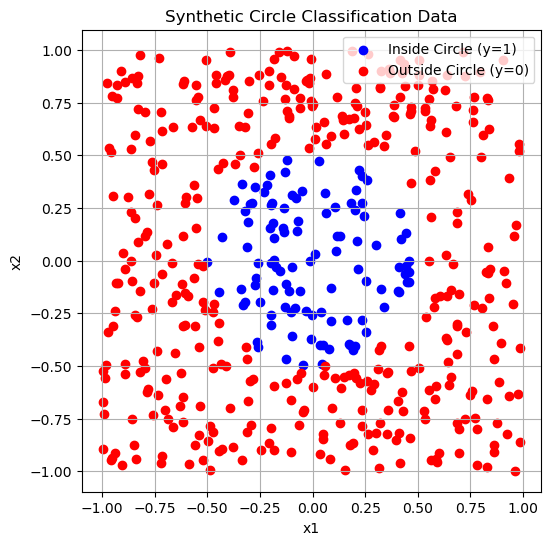

In [11]:
plt.figure(figsize=(6, 6))
plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='blue', label='Inside Circle (y=1)')
plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='red', label='Outside Circle (y=0)')
plt.gca().set_aspect('equal')
plt.title("Synthetic Circle Classification Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()


## 2: initialize the parameters to be random variables. initialize k1 and k2 as random keys.  use k1 for W1 and k2 for W2.

In [30]:
import jax
from jax import grad
from jax.nn import relu, sigmoid
import optax  # for optimization

def init_params(key, hidden_dim=8, scale = 0.1):
    k1, k2 = jax.random.split(key)#TODO: fill here  random keys k1 and k2 . use k1 for W1 and k2 for W2
    W1 = scale * jax.random.normal(k1, (2, hidden_dim))
    b1 = jnp.zeros((1, hidden_dim))
    W2 = scale * jax.random.normal(k2, (hidden_dim, 1))
    b2 = jnp.zeros((1,))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}


## 3: define  the forward step for the neural network based on the parameters of the network.

In [31]:
def forward(params, x):
    z1 = jnp.dot(x, params['W1']) + params['b1']
    a1 = relu(z1)
    z2 = jnp.dot(a1, params['W2']) + params['b2']
    return sigmoid(z2)


## 4 : define the loss function as the binary cross entropy loss.

In [32]:
def loss(params, x, y):
    y_pred = forward(params, x)
    return -jnp.mean(y * jnp.log(y_pred + 1e-7) + (1 - y) * jnp.log(1 - y_pred + 1e-7))


## 5: fill the update function to calculate gradients on each step.

In [33]:
# Generate random key
key = jax.random.PRNGKey(0)

# Create initial parameters
params = init_params(key)

opt = optax.sgd(learning_rate=0.1)
opt_state = opt.init(params)
@jax.jit
def update(params, opt_state, x, y):
    grads = jax.grad(loss)(params, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state


In [34]:
losses = []
for epoch in range(10000):
    params, opt_state = update(params, opt_state, X, y)
    l = loss(params, X, y)
    losses.append(l)


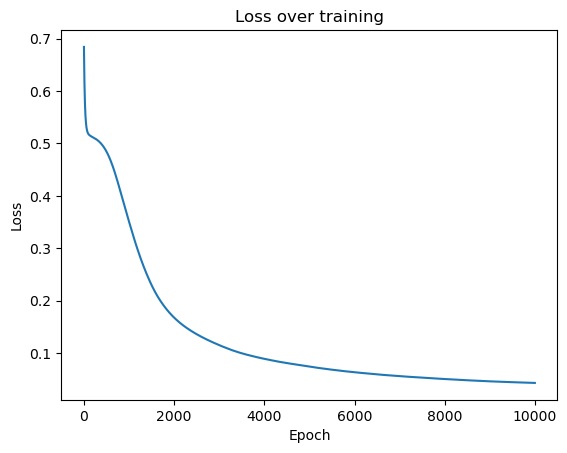

In [35]:
plt.plot(losses)
plt.title("Loss over training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


## 6: Plot the decision boundaries for the network.

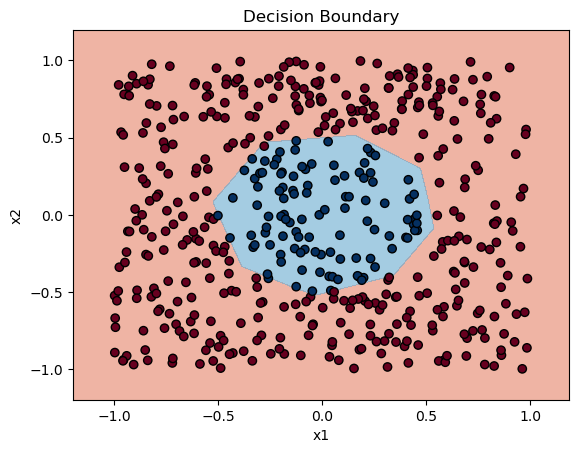

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Create a meshgrid over input space
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.2, X[:,0].max()+0.2, 200),
                     np.linspace(X[:,1].min()-0.2, X[:,1].max()+0.2, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_pred = forward(params, jnp.array(grid))
# print(grid_pred.shape)
grid_pred = np.array(grid_pred).reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, grid_pred, levels=[0, 0.5, 1], alpha=0.6, cmap='RdBu')
plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k', cmap='RdBu')
plt.title("Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()
